In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from collections import defaultdict

In [2]:
def concate_density_dataframes(file_list, std_dev_factor = 1):
    """
    conctact dataframe locatated in a directory and filter the density value with std_dev_factor
    """
    df = pd.DataFrame()
    densities = []
    
    
    for file in file_list:
        df_image = pd.read_csv(file, index_col=0)
        densities.append(df_image.densities)
        
    densities_mean = np.mean(densities)
    std_dev = np.std(densities) * 1
    df = pd.DataFrame()
    frames = []
    for file in file_list:
        df_image = pd.read_csv(file, index_col=0)
        if np.mean(df_image.densities) < std_dev:
            print(np.unique(df_image.image))
        else:
            frames.append(df_image)
    
    return pd.concat(frames)

In [3]:
def get_filtered_density_df(images_id, density_df,):
    image_id = list(density_df['image'])
    mask = density_df.image.isin(images_id)
    return density_df[mask]

In [4]:
def plot(densities_per_depth, title,  plot_median=False, plt_detail=False, display_legend=False):
    """
    :param densities: np.array of np.float.32 of shape (nb_images, nb_percentages, 2) 2-> depth_percentage, density
    """

            
    average={}
    median={}
    plt.figure(figsize=(5,5))
    
    density_dict=defaultdict(list)
    for density in densities_per_depth:
        densities_value = density[:,1]
        depthes = density[:,0]
        if plt_detail:
            plt.plot(densities_value, depthes)
        for density, depth in zip(densities_value, depthes):
            density_dict[depth].append(density)

    for depth, densities in density_dict.items():  
        average[depth] = np.average(densities)      
        median[depth] = np.median(densities)   

    
    plt.plot(list(average.values()), list(average.keys()), linewidth=3, c='black', label='average values')
    if plot_median:
        plt.plot(list(median.values()), list(median.keys()), linewidth=3, c='khaki', label='average values')
    plt.title(f'{title}')
    plt.gca().set_xlabel("Cell density cells/mm3")
    plt.gca().set_ylabel("percentage of depth [%]")
    
    plt.gca().invert_yaxis()
    
    if display_legend:
        lgnd = plt.legend(loc="upper left", scatterpoints=1, fontsize=10)
        for i in range(1):
            lgnd.legendHandles[i]._sizes = [5]
            lgnd.legendHandles[i]._alpha = 1 
   

In [63]:
def plot_mean_and_std_dev(density_dfs, labels='' , colors='blue', title=None):

    '''
    param: density_df' list of (or a single) pandas dataframe with columns : image 	depth_percentage densities
    '''

    if not isinstance(density_dfs, list):
        density_dfs = [density_dfs]

    if not isinstance(labels, list):
        labels = [labels]    

    if not isinstance(colors, list):
        labels = [colors]    


    
    plt.figure(figsize=(5,5))
    for density_df, label, color in zip(density_dfs, labels, colors):
        percentage = np.unique(density_df.depth_percentage)
        densities = np.array(list(density_df.groupby('depth_percentage')['densities'].apply(list).values))
        
        density_std = np.std(densities, axis=1)
        density_mean = densities.mean(axis=1)
        
        
        _=plt.plot (density_mean, percentage, label=label + ' Mean densities', linewidth=4, c=color)
        _=plt.fill_betweenx(percentage,density_mean-density_std,density_mean+density_std,alpha=.3, color=color,
                            label= label + ' Standard deviation')
        plt.legend()
        
        plt.gca().set_xlabel("Cell density [cells/mm$^3$]")
        plt.gca().set_ylabel("Standard cortical depth [%]]")

    plt.gca().invert_yaxis()
    if title: plt.title(title)

    

In [6]:
def dataframe_to_array(dataframe):
    # compute the average cell density
    densities = []
    for image in np.unique(dataframe.image):
        image_data = dataframe[dataframe['image']==image].to_numpy()[:,[1,2]]
        densities.append(image_data)
    return  np.array(densities, dtype=np.float32)
    

In [7]:
per_percentage_path = '/gpfs/bbp.cscs.ch/project/proj53/CellDensitiesProject/Production/2024/Density/01242024/Per_percentage/'
file_list = glob.glob(per_percentage_path + '*.csv')
density_df = concate_density_dataframes(file_list)

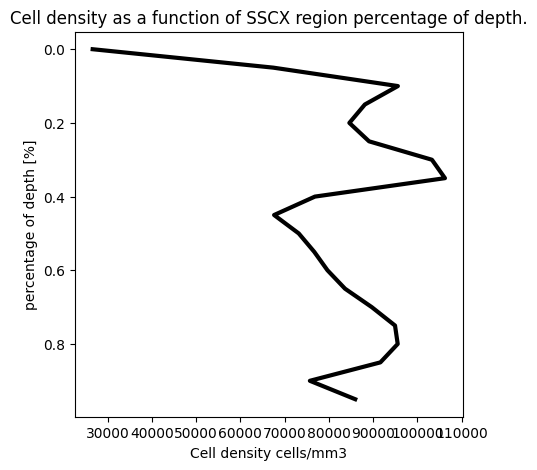

In [8]:
data = dataframe_to_array(density_df)
plot(data, 'Cell density as a function of SSCX region percentage of depth.')

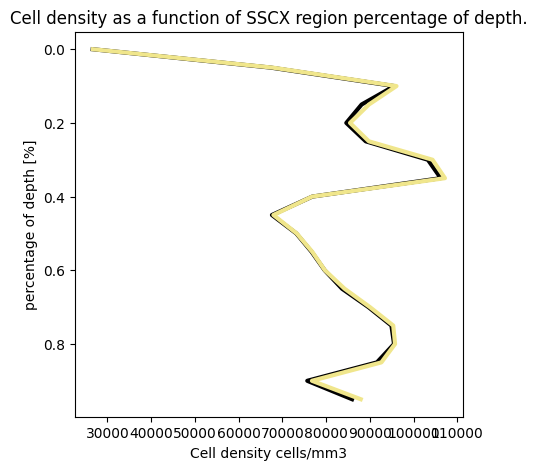

In [9]:
plot(data, 'Cell density as a function of SSCX region percentage of depth.', plot_median=True, plt_detail=False)

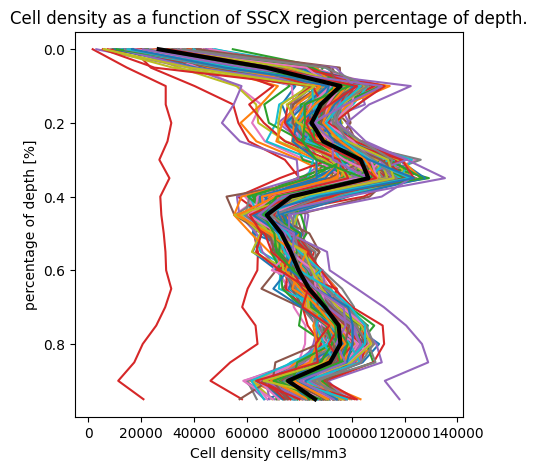

In [10]:
plot(data, 'Cell density as a function of SSCX region percentage of depth.', plt_detail=True)

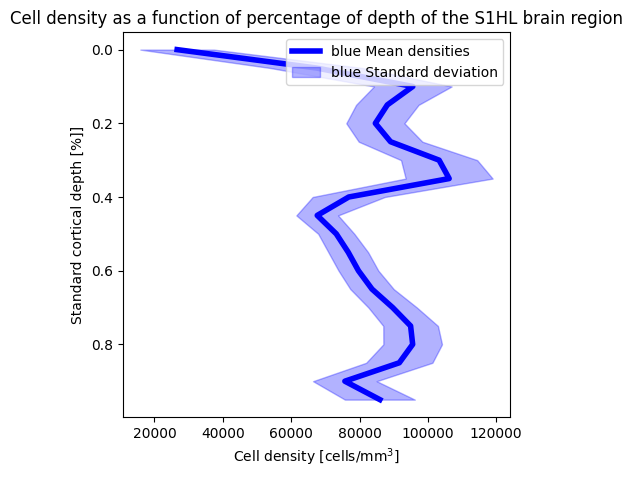

In [64]:
plot_mean_and_std_dev(density_df, 
                      title="Cell density as a function of percentage of depth of the S1HL brain region")

In [12]:
meta_df = pd.read_csv('/gpfs/bbp.cscs.ch/project/proj53/LayerBoundariesProject/Production/20231102/datasets/Exported_Features/Dataframes/metadata.csv', index_col=0)

In [13]:
analyse_df = meta_df[meta_df.Analyze == True]
left_meta_df = analyse_df[analyse_df['hemisphere(L/R)']=='left']
right_meta_df = analyse_df[analyse_df['hemisphere(L/R)']=='right']

In [14]:
left_image_id = list(left_meta_df['Image_Name'])
right_image_id = list(right_meta_df['Image_Name'])
left_density_df = get_filtered_density_df(left_image_id, density_df)
right_density_df = get_filtered_density_df(right_image_id, density_df)

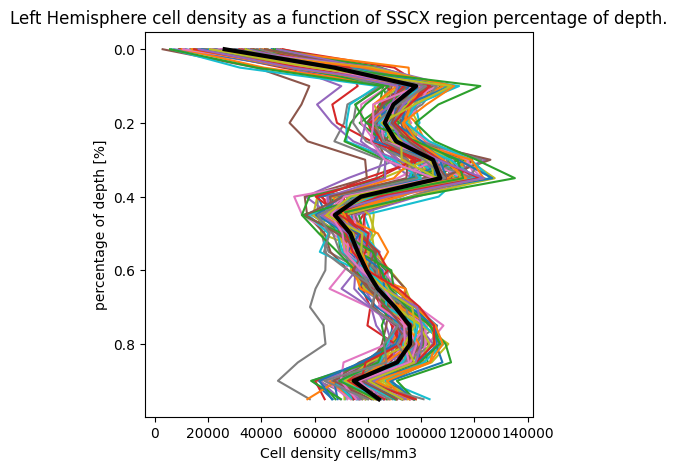

In [66]:
data = dataframe_to_array(left_density_df)
plot(data, 'Left Hemisphere cell density as a function of SSCX region percentage of depth.', plt_detail=True)

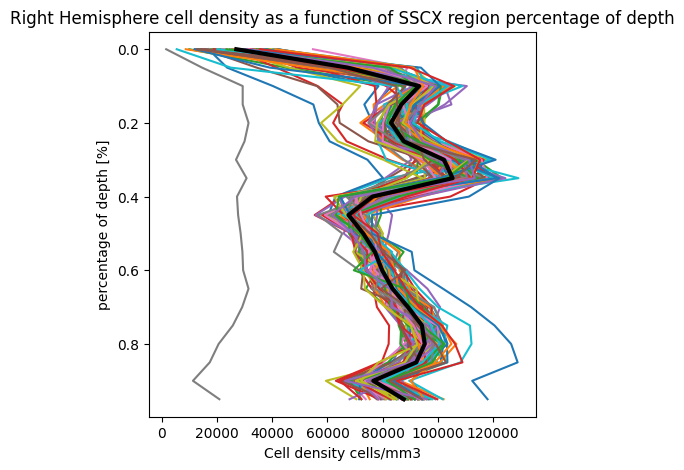

In [68]:
data = dataframe_to_array(right_density_df)
plot(data, 'Right Hemisphere cell density as a function of SSCX region percentage of depth', plt_detail=True)

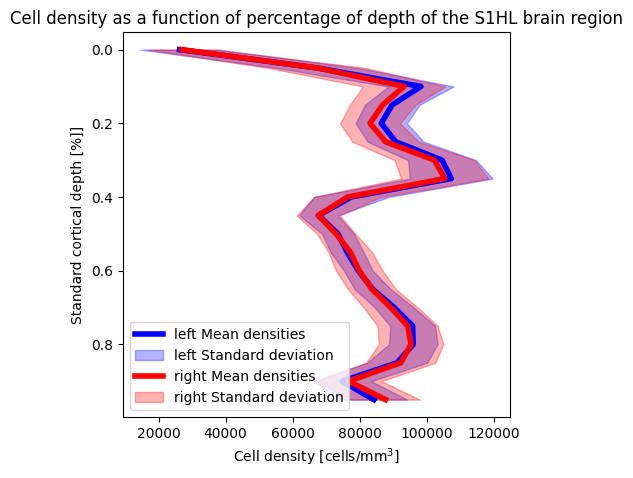

In [65]:
plot_mean_and_std_dev([left_density_df,right_density_df], 
                      labels=['left', 'right'],
                      colors=['blue', 'red'],
                      title="Cell density as a function of percentage of depth of the S1HL brain region")


In [72]:
project_ID_list = np.unique(analyse_df['Project_ID'])
project_ID_list

array(['ProjectQuPath_01413827_LH_Nissl_2',
       'ProjectQuPath_01413827_RH_Nissl_1',
       'ProjectQuPath_01413828_RH_Nissl_2',
       'ProjectQuPath_01413829_RH_Nissl_2',
       'ProjectQuPath_1413828_LH_Nissl_3',
       'ProjectQuPath_1443459_RH_Nissl_4',
       'ProjectQuPath_1443460_LH_Nissl_5',
       'ProjectQuPath_1443460_RH_Nissl_4',
       'ProjectQuPath_1449920_LH_Nissl_6',
       'ProjectQuPath_1449921_LH_Nissl_6',
       'ProjectQuPath_1449921_RH_Nissl_6',
       'ProjectQuPath_1449922_LH_Nissl_6',
       'ProjectQuPath_1449922_RH_Nissl_6'], dtype=object)

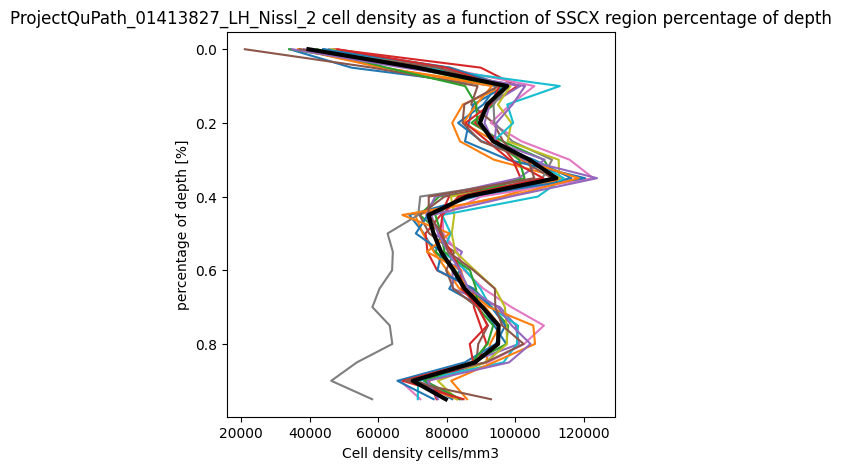

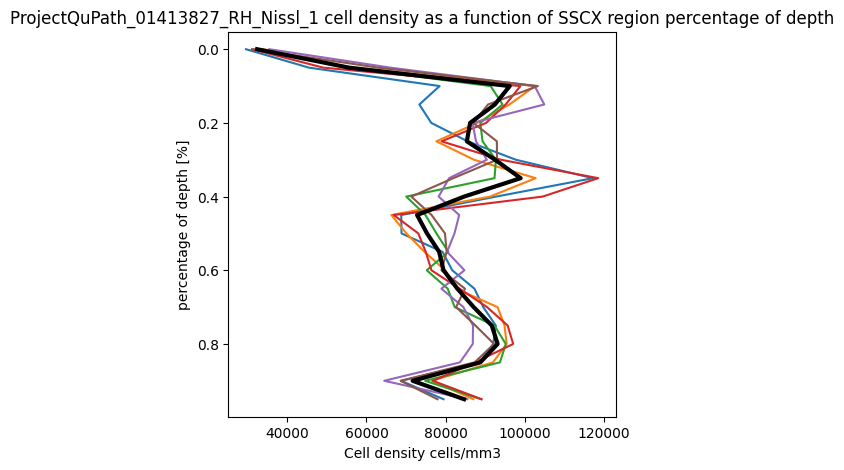

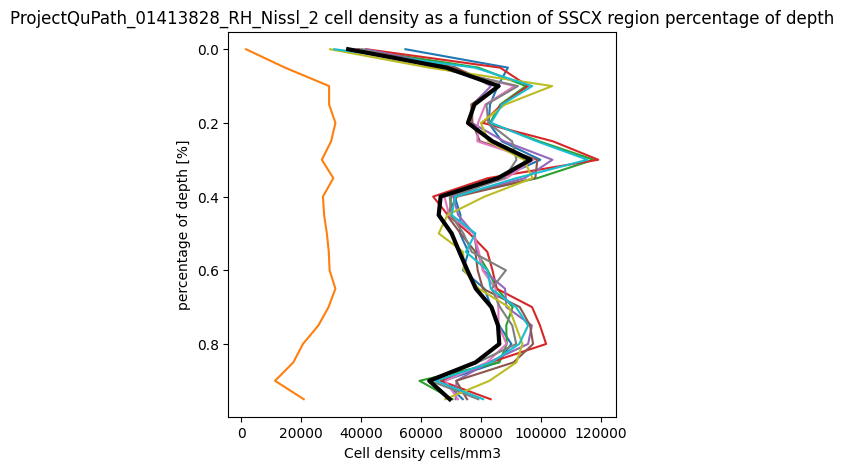

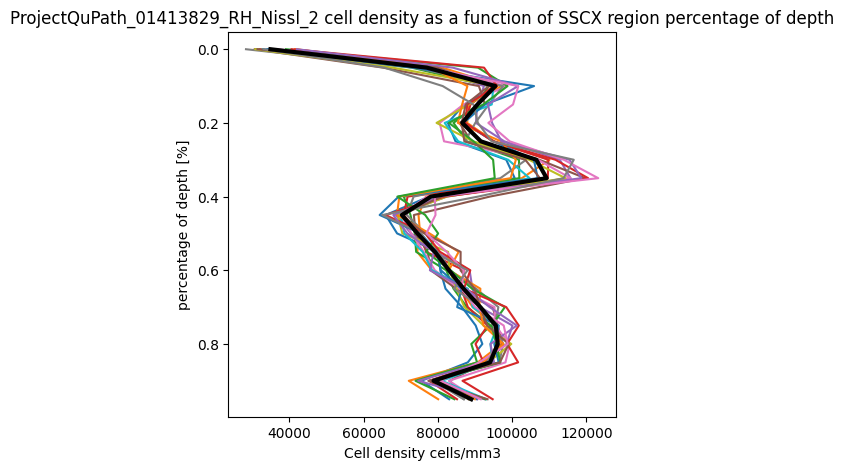

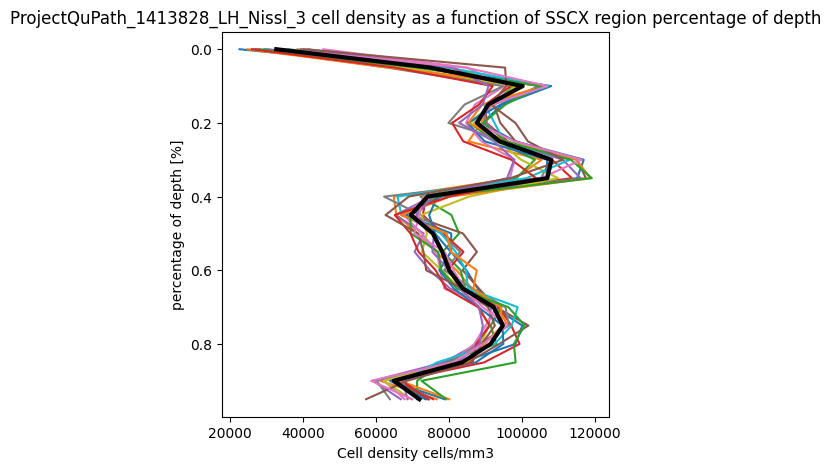

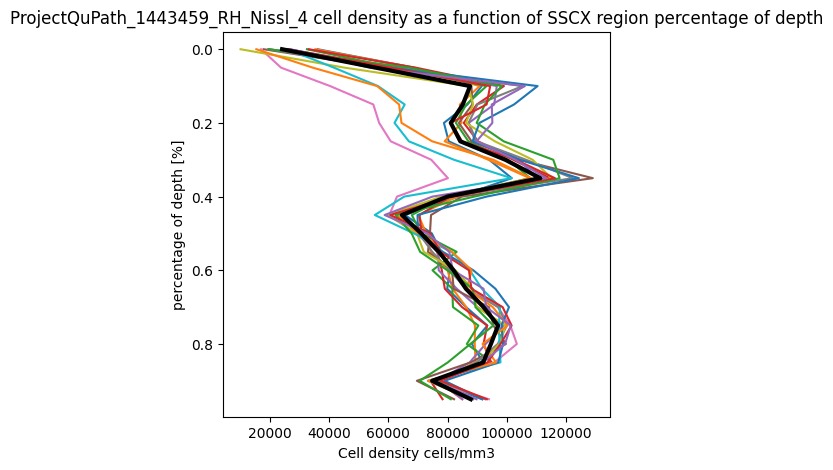

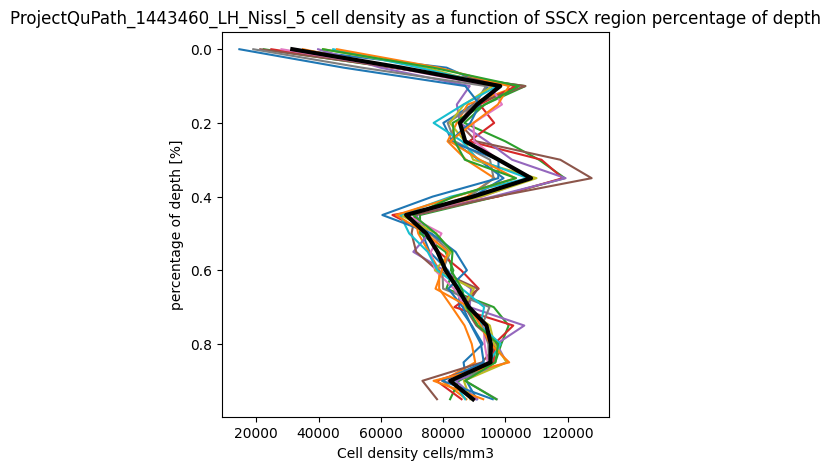

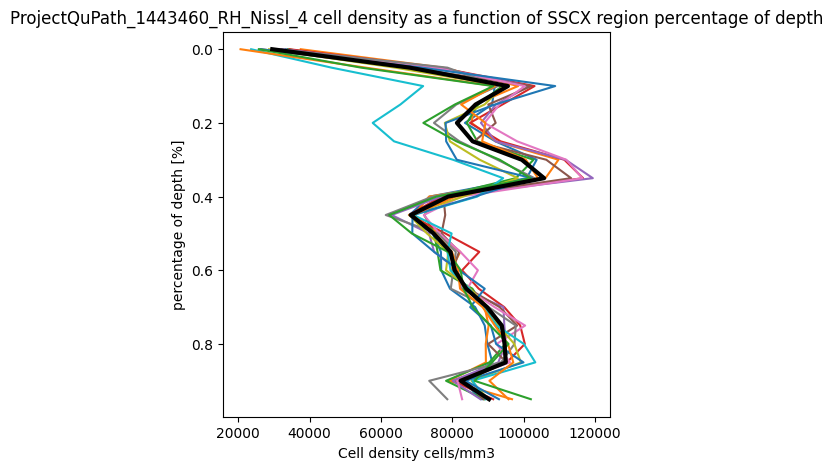

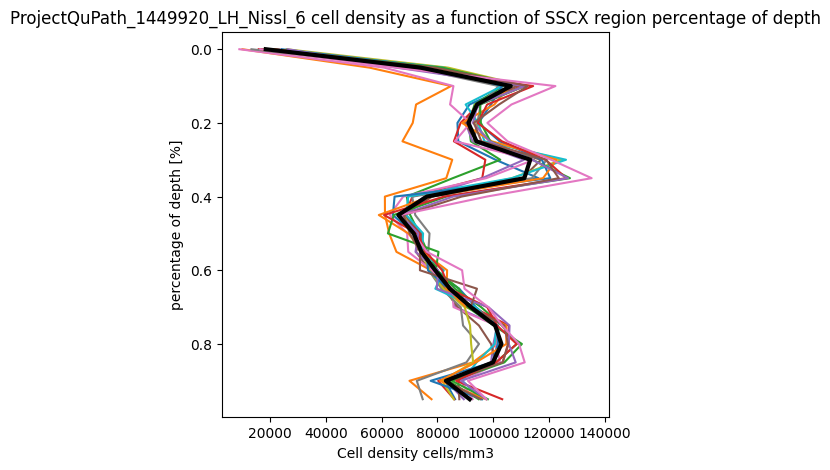

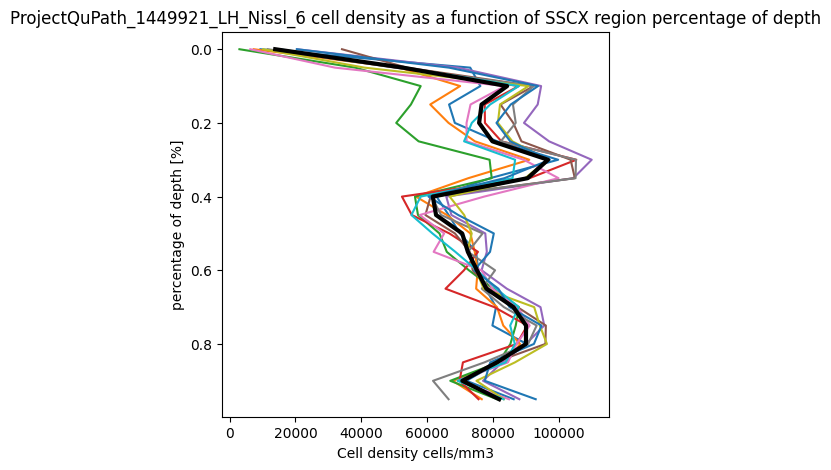

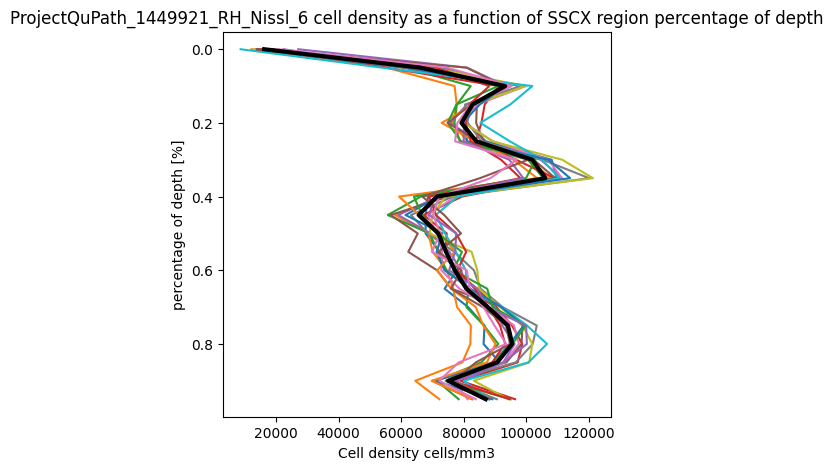

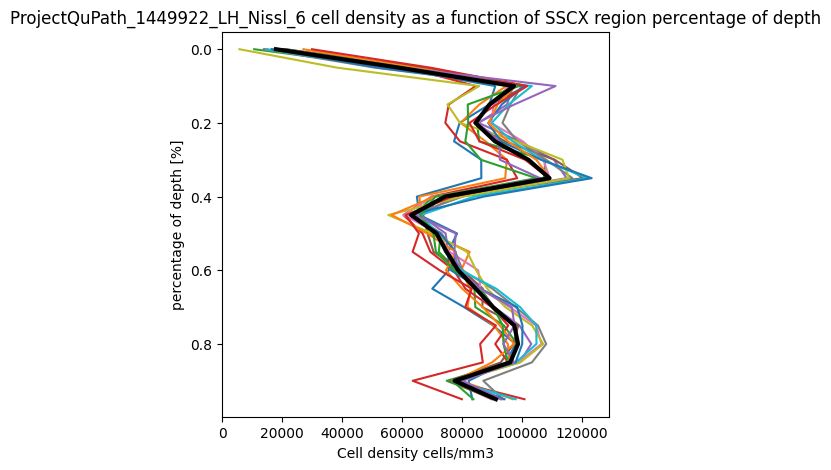

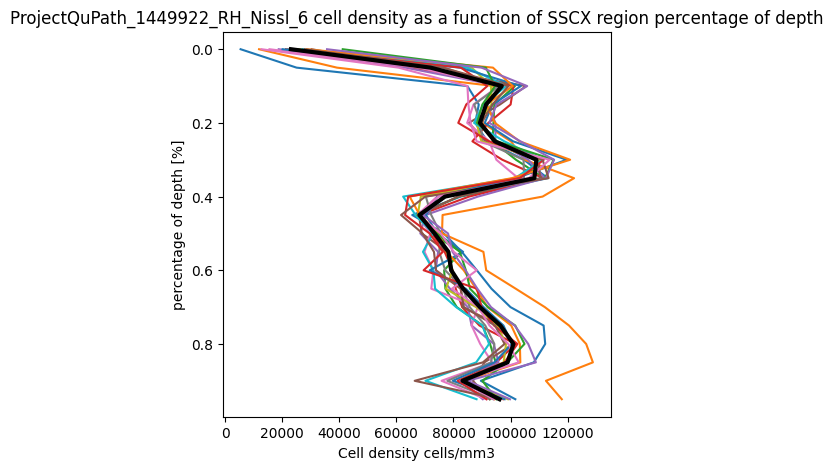

In [81]:
for project_id in project_ID_list:
    animal_meta_df = analyse_df[analyse_df['Project_ID']==project_id]
    animal_image_id = list(animal_meta_df['Image_Name'])
    animal_density_df = get_filtered_density_df(animal_image_id, density_df)
    data = dataframe_to_array(animal_density_df)
    plot(data, f'{project_id} cell density as a function of SSCX region percentage of depth', plt_detail=True)

,image,depth_percentage,densities
0,SLD_0000440.vsi-20x_01,0.00,48072.675859
1,SLD_0000440.vsi-20x_01,0.05,79746.656318
2,SLD_0000440.vsi-20x_01,0.10,95421.252205
3,SLD_0000440.vsi-20x_01,0.15,92834.284124
4,SLD_0000440.vsi-20x_01,0.20,85484.808096
...,...,...,...
15,SLD_0000437.vsi-20x_01,0.75,93606.897901
16,SLD_0000437.vsi-20x_01,0.80,91964.240361
17,SLD_0000437.vsi-20x_01,0.85,87290.599653
18,SLD_0000437.vsi-20x_01,0.90,73576.410386
